In [1]:
%matplotlib inline
import os

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import MaxPooling2D, Conv2D, Input, RepeatVector
from keras.layers import Reshape, concatenate, Conv2DTranspose
from keras import optimizers, callbacks
from scipy import stats
import numpy as np
import cv2

Using TensorFlow backend.


In [2]:
DATA_PATH = 'data/'
X_IMG_PATH = DATA_PATH + 'images/'
Y_IMG_PATH = DATA_PATH + 'labels/'

INPUT_SIZE = (128, 128)
POS_THRESHOLD = .5

In [3]:
def preprocess_img(filepath, test_img=False):
    img = cv2.imread(filepath)
    img_resized = cv2.resize(img, INPUT_SIZE)
    
    if test_img:
        img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        img_resized = np.expand_dims(img_resized, 3)
        img_resized = (img_resized > POS_THRESHOLD).astype(np.float32)
    else:
        img_resized = img_resized.astype(np.float32)
        for i in range(len(img_resized.shape)):  # Mean subtraction
            img_resized[i] -= np.mean(img_resized[i])
        
    return img_resized

files = os.listdir(X_IMG_PATH)
original = [cv2.imread(X_IMG_PATH + fname) for fname in files]
images_all = np.array([preprocess_img(X_IMG_PATH + fname) for fname in files])
labels_all = np.array([preprocess_img(Y_IMG_PATH + fname, True) for fname in files])

/home/mateusz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  import sys


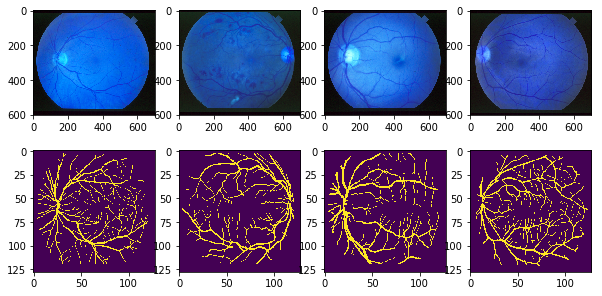

In [4]:
N_SHOW = 4  # How many examples should be shown
f, axarr = plt.subplots(2, N_SHOW, figsize=(10,5))

for i in range(N_SHOW):
    axarr[0, i].imshow(original[i])
    axarr[1, i].imshow(labels_all[i,:,:,0])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images_all,
                                                    labels_all,
                                                    test_size=0.2)
images_all.shape

(20, 128, 128, 3)

In [6]:
# Source: https://www.kaggle.com/bguberfain/unet-with-depth
input_img = Input((*INPUT_SIZE, 3), name='img')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

optimizer = optimizers.Adam(lr=1e-5)
model = Model(inputs=[input_img], outputs=[outputs])
model.compile(optimizer='adam', metrics=['acc'], loss='binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  224         img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [8]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')
model.fit(X_train, y_train,
          batch_size=32, epochs=500,
          validation_data=(X_test, y_test),
          callbacks=[es])

Instructions for updating:
Use tf.cast instead.
Train on 16 samples, validate on 4 samples
Epoch 1/500
16/16 [==============================] - 3s 207ms/step - loss: 1.4377 - acc: 0.8633 - val_loss: 0.9065 - val_acc: 0.8233
Epoch 2/500
16/16 [==============================] - 0s 3ms/step - loss: 0.9216 - acc: 0.8124 - val_loss: 0.8172 - val_acc: 0.6603
Epoch 3/500
16/16 [==============================] - 0s 3ms/step - loss: 0.9295 - acc: 0.6168 - val_loss: 0.6548 - val_acc: 0.7452
Epoch 4/500
16/16 [==============================] - 0s 2ms/step - loss: 0.6990 - acc: 0.7103 - val_loss: 0.5896 - val_acc: 0.8241
Epoch 5/500
16/16 [==============================] - 0s 3ms/step - loss: 0.5888 - acc: 0.8151 - val_loss: 0.5682 - val_acc: 0.8551
Epoch 6/500
16/16 [==============================] - 0s 2ms/step - loss: 0.5695 - acc: 0.8461 - val_loss: 0.5381 - val_acc: 0.8603
Epoch 7/500
16/16 [==============================] - 0s 2ms/step - loss: 0.5435 - acc: 0.8508 - val_loss: 0.5226 - val_ac

Epoch 61/500
16/16 [==============================] - 0s 2ms/step - loss: 0.2297 - acc: 0.9156 - val_loss: 0.2176 - val_acc: 0.9293
Epoch 62/500
16/16 [==============================] - 0s 2ms/step - loss: 0.2286 - acc: 0.9161 - val_loss: 0.2169 - val_acc: 0.9295
Epoch 63/500
16/16 [==============================] - 0s 2ms/step - loss: 0.2276 - acc: 0.9166 - val_loss: 0.2163 - val_acc: 0.9296
Epoch 64/500
16/16 [==============================] - 0s 2ms/step - loss: 0.2267 - acc: 0.9164 - val_loss: 0.2159 - val_acc: 0.9301
Epoch 65/500
16/16 [==============================] - 0s 2ms/step - loss: 0.2260 - acc: 0.9176 - val_loss: 0.2154 - val_acc: 0.9297
Epoch 66/500
16/16 [==============================] - 0s 2ms/step - loss: 0.2254 - acc: 0.9165 - val_loss: 0.2159 - val_acc: 0.9302
Epoch 67/500
16/16 [==============================] - 0s 2ms/step - loss: 0.2255 - acc: 0.9187 - val_loss: 0.2141 - val_acc: 0.9298
Epoch 68/500
16/16 [==============================] - 0s 2ms/step - loss: 0.

Epoch 123/500
16/16 [==============================] - 0s 2ms/step - loss: 0.1882 - acc: 0.9337 - val_loss: 0.1962 - val_acc: 0.9367
Epoch 124/500
16/16 [==============================] - 0s 2ms/step - loss: 0.1876 - acc: 0.9295 - val_loss: 0.1945 - val_acc: 0.9367
Epoch 125/500
16/16 [==============================] - 0s 2ms/step - loss: 0.1827 - acc: 0.9334 - val_loss: 0.1951 - val_acc: 0.9368
Epoch 126/500
16/16 [==============================] - 0s 2ms/step - loss: 0.1820 - acc: 0.9336 - val_loss: 0.1962 - val_acc: 0.9370
Epoch 127/500
16/16 [==============================] - 0s 2ms/step - loss: 0.1844 - acc: 0.9309 - val_loss: 0.1988 - val_acc: 0.9357
Epoch 128/500
16/16 [==============================] - 0s 2ms/step - loss: 0.1842 - acc: 0.9349 - val_loss: 0.1929 - val_acc: 0.9375
Epoch 129/500
16/16 [==============================] - 0s 2ms/step - loss: 0.1799 - acc: 0.9328 - val_loss: 0.1938 - val_acc: 0.9375
Epoch 130/500
16/16 [==============================] - 0s 2ms/step - 

In [9]:
def process_predictions(y_hat):
    new_shape = (y_hat.shape[0], *INPUT_SIZE)
    y_proc = np.reshape(y_hat, new_shape)
    return y_proc

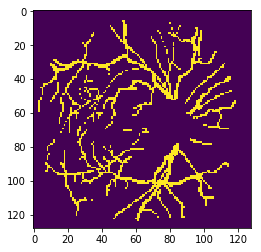

In [10]:
y_true_proc = process_predictions(y_test)
plt.imshow(y_true_proc[0])

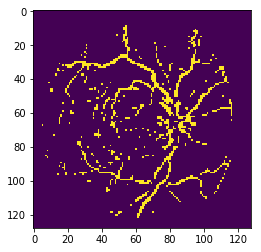

In [12]:
y_hat = model.predict(X_test)
y_hat_proc = process_predictions(y_hat)
plt.imshow(y_hat_proc[0] > POS_THRESHOLD)